# Practical machine learning and deep learning. Lab 1
# Tools and Processes for Machine Learning and Data Analysis

## [Competition](https://www.kaggle.com/t/fa8bbded119a4cb6a0f5b92601a2122a)

### Goal
Labs will be conducted with use of [Kaggle](https://www.kaggle.com). 

The aim of today's lab is to find out how the next labs will be held and recap ML workflow.

Also, you have two tasks: 1) recap the training flow of a neural network and 2) use a traking tool to control this flow. 

### Submission
Your are asked to implement a neural network to classify if there is a person with blond hairs on a photo and generate `submission.csv` for the test set.

### Frameworks we're using in this lab

#### PyTorch
   PyTorch is an open-source machine learning library primarily developed by Meta's (компания признана экстремистской организацией на территории Российской Федерации) AI Research lab . It is widely used for deep learning tasks.

#### Tensorboard
   TensorBoard is a visualization tool provided by TensorFlow for monitoring and visualizing the training process and model performance during machine learning experiments.


#### ClearML
   ClearML is an open-source machine learning platform designed to automate and streamline the end-to-end machine learning workflow, including data management, model training, and deployment.

In [1]:
# We will use tensorboard as logging tool. However kaggle does not allow to view it.
# !pip install tensorboard

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 1. Data set

Data set, a part of [CelebA](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/data), contains about 11,000 images with cropped faces. Your task is to detect people with blond hairs, or do binary classification (blondy\not blondy) for each image. 

There are several small challenges you're going to face with the dataset. First, the size of images is much bigger than for regular learning sets -  178 by 218 pixels in RGB scale. Second, CelebA dataset is quite well-labeled, and each image has lots of metainfo about face features. Usually they are used to train generative or face recognition models. We intentionally left all of these features, which are redundant for solving this task.

Please do not train a classifier on other data than given (including other parts of CelebA). 

## 1.1 Data preprocessing

In [3]:
# necessary imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as transforms
from torchvision.io import read_image

In [4]:
def load_img(fname):
    img = read_image(fname)
    x = img / 255.

    transform = transforms.Compose(
        [
            #   Here you can add more augmentations.
            #   See documentation: https://pytorch.org/vision/stable/transforms.html
            transforms.Resize((82,82)),
        ]
    )

    return transform(x)

In [6]:
img_path = "/kaggle/input/pmldl-week-1-dnn-training-with-tracking-tools/archive"

train_features = pd.read_csv(f"{img_path}/train.csv")

labels = train_features[["Blond_Hair", "Gray_Hair", "Brown_Hair","Black_Hair"]]
labels.replace(-1, 0, inplace=True)

# convert data to tensors
images = torch.stack([load_img(f"{img_path}/img_align_celeba/train/{item['image_id']}") for _, item in  train_features.iterrows()])
labels = torch.from_numpy(labels.to_numpy()).float()


In [7]:
# just some checking of shapes
images.shape, labels.shape


(torch.Size([11785, 3, 82, 82]), torch.Size([11785, 4]))

## 1.2 Visualization

In [6]:
import matplotlib.pyplot as plt


def plot_images(images, captions=[], rows=2, columns=5, title="", **kwargs):
    """
    Plots images with captions

    :param images: list of images to plot
    :param captions: captions of images:
    :param rows: number of rows in figure
    :param columns: number of columns:
    :param title: super title of figure
    """
    fig = plt.figure(figsize=(6, 3))
    for i, img in enumerate(images):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img, **kwargs)
        if i < len(captions):
            plt.title(captions[i])
        plt.axis("off")
    fig.suptitle(title)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


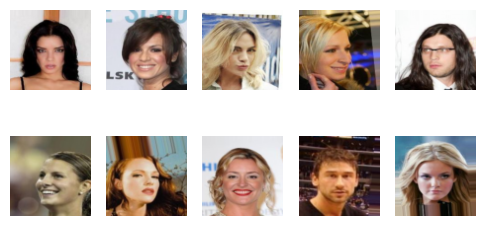

In [7]:
# Visualise 10 images from the dataset
plot_images(images[:10].permute((0, 2, 3, 1)), cmap="gray")


## 1.3 Data loaders creation

In [8]:
from torch.utils.data import TensorDataset, DataLoader

processed_dataset = TensorDataset(images, labels)

# set proportion and split dataset into train and validation parts
proportion = 0.90

train_dataset, val_dataset = torch.utils.data.random_split(
    processed_dataset,
   [(int(len(images) * proportion)), len(images) - int(len(images) * proportion)],
)


In [9]:
# Create Dataloaders for training
# Dataloader is iterable object over dataset
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


## 2. Training


## 2.1 Defining a model

We will implement CNN

> if you want higher score implement any suitable model you know and like

In [10]:
class CNNClassificationModel(nn.Module):
    """
    CNN (convolutional neural network) based classification model
    """

    def __init__(self, num_classes=4):
        super(CNNClassificationModel, self).__init__()
        feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((6, 6)),
        )
        classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 1024),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

        self.model = nn.Sequential(feature_extractor, nn.Flatten(), classifier)

    def forward(self, x):
        return self.model(x)


## 2.2 Defining training & validation loops

Here is the sample function for training procedure. 
We save the checkpoints with best accuracy score. For the inference you need to load it to the model.

> You can add early stopping if you want for better results

In [19]:
def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    writer,
    epochs=1,
    device="cpu",
    ckpt_path="best.pt",
):
    # best score for checkpointing
    best = 0.0
    
    # iterating over epochs
    for epoch in range(epochs):
        # training loop description
        train_loop = tqdm(
            enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch}"
        )
        model.train()
        train_loss = 0.0
        # iterate over dataset 
        for i, data in train_loop:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass and loss calculation
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            # backward pass
            loss.backward()

            # optimizer run
            optimizer.step()

            train_loss += loss.item()
            train_loop.set_postfix({"loss": loss.item()})

        # write loss to tensorboard
        writer.add_scalar("Loss/train", train_loss / len(train_loader), epoch)
        
        # validation
        correct = 0
        total = 0
        with torch.no_grad():
            model.eval()  # evaluation mode
            val_loop = tqdm(enumerate(val_loader, 0), total=len(val_loader), desc="Val")
            for i, data in val_loop:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                _, predicted = torch.max(outputs, 1)
                _, labels_ = torch.max(labels, 1)
                total += labels.size(0)

                correct += (predicted == labels_).sum().item()

                val_loop.set_postfix({"acc": correct / total})

            if correct / total > best:
                torch.save(model.state_dict(), ckpt_path)
                best = correct / total

        writer.add_scalar("Accuracy/val", correct / total, epoch)

## 2.3 Combining everything together

In [12]:
model = CNNClassificationModel()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
device = 'cpu' 
writer = SummaryWriter()
print(device)

train(
    model,
    optimizer,
    loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    writer=writer,
    epochs=2
)


cpu


Epoch 0:   0%|          | 0/166 [00:00<?, ?it/s]

Val:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/166 [00:00<?, ?it/s]

Val:   0%|          | 0/19 [00:00<?, ?it/s]

## 2.4 Inference
Here you need to perform inference of trained model on test data. 

Load the best checkpoint from training to the model and run inference

In [14]:
# load best checkpoint to model
model = CNNClassificationModel()
ckpt = torch.load("best.pt")
model.load_state_dict(ckpt)

<All keys matched successfully>

In [15]:
def predict(model, test_loader, device):
    """
    Run model inference on test data
    """
    predictions = []
    with torch.no_grad():
        model.eval()  # evaluation mode
        test_loop = tqdm(enumerate(test_loader, 0), total=len(test_loader), desc="Test")
        for i, inputs in test_loop:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predicted = [int(i == 0) for i in predicted]
            predictions.extend(predicted)
        return predictions

def load_training_img(fname):
    img = read_image(fname)
    x = img / 255.

    transform = transforms.Compose(
        [
            # Do not apply data augmentation from training, but make sure 
            transforms.Resize((82,82)),
        ]
    )

    return transform(x) 

In [16]:
# process test data and run inference on it
test_features = pd.read_csv(f"{img_path}/test.csv")
images = torch.stack([load_img(f"{img_path}/img_align_celeba/test/{item['image_id']}") for _, item in  test_features.iterrows()])

test_loader = DataLoader(images, batch_size=batch_size, shuffle=False)
predictions = predict(model, test_loader, device=device)

# generate the submission file
submission_df = pd.DataFrame(columns=['ID', 'Blond_Hair'])
submission_df['ID'] = test_features.index
submission_df['Blond_Hair'] = predictions
submission_df.to_csv('submission.csv', index=False)
submission_df.head()

Test:   0%|          | 0/16 [00:00<?, ?it/s]

,ID,Blond_Hair
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0


## 3 Training tracking - [ClearML](https://clear.ml/docs/latest/docs/getting_started/ds/ds_first_steps/) or Tensorboard

In [18]:
# Kaggle has no support of viewing tensorboard. Run this if you are using your machine
# to see logs.
# !tensorboard --logdir . 

Tensorboard should like this
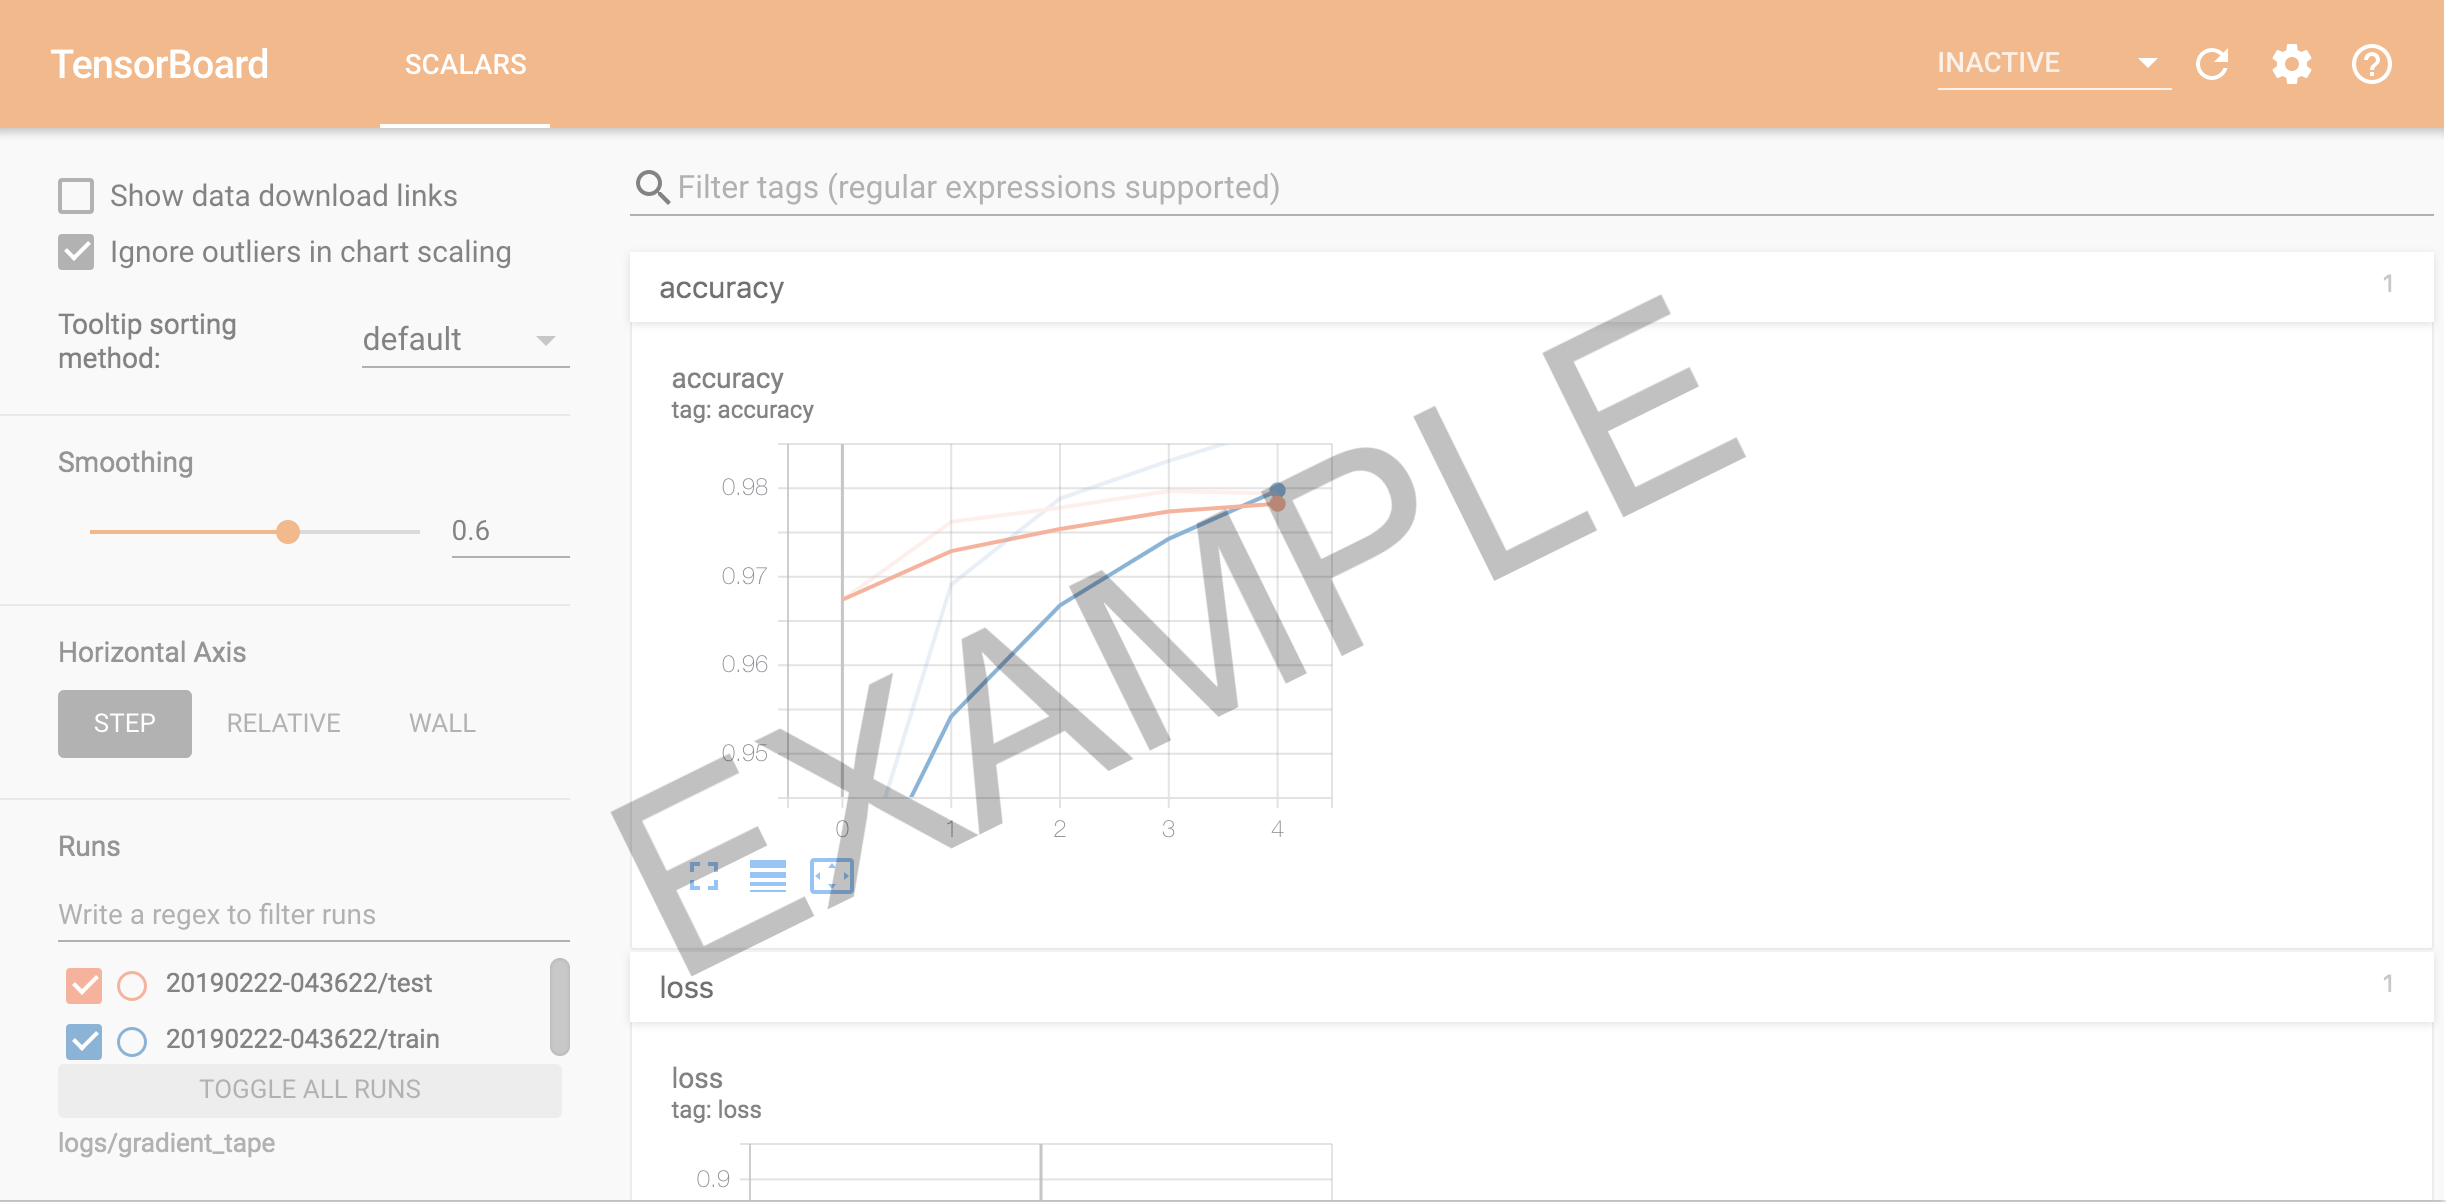

#### Configuring ClearML

1) Sign up in  [ClearMl](https://clear.ml)
2) Install clearml as python package: pip install clearml
3) Get [credentials](https://app.clear.ml/settings/workspace-configuration) to connect your notebook with remote server. When creating new credentials, pick Jupyter notebook tab.  ![clearml.png](clearml.png)
4) Put these env variables 
5) Run !clearml-init
6) Uncomment code in the next cell 

In [18]:
# %pip install clearml
!clearml-init


ClearML SDK setup process

Please create new clearml credentials through the settings page in your `clearml-server` web app (e.g. http://localhost:8080//settings/workspace-configuration) 
Or create a free account at https://app.clear.ml/settings/workspace-configuration

In settings page, press "Create new credentials", then press "Copy to clipboard".

Paste copied configuration here:
^C
Traceback (most recent call last):
  File "/opt/homebrew/bin/clearml-init", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/clearml/cli/config/__main__.py", line 82, in main
    api_input = input()
                ^^^^^^^
KeyboardInterrupt


In [1]:
# Run this cell to start monitoring the training
from clearml import Task

task = Task.init(task_name="classifier_training", project_name="pmldl-lab1")

ClearML Task: created new task id=6f65b2d04f2c4dbd8631747e2f8111a5
2025-08-25 22:50:01,626 - clearml.Task - INFO - Storing jupyter notebook directly as code
2025-08-25 22:50:01,917 - clearml.Repository Detection - WARNING - Could not read Jupyter Notebook: No template sub-directory with name 'script' found in the following paths:
	/Users/romangaraev/Library/Jupyter
	/Users/romangaraev/Library/Python/3.11/share/jupyter
	/opt/homebrew/opt/python@3.11/Frameworks/Python.framework/Versions/3.11/share/jupyter
	/usr/local/share/jupyter
	/usr/share/jupyter
ClearML results page: https://app.clear.ml/projects/a3d6a36e496c4df890210e7b80e0f631/experiments/6f65b2d04f2c4dbd8631747e2f8111a5/output/log


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


In [20]:
# try again...
model = CNNClassificationModel()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
device = 'cpu' 
writer = SummaryWriter()
print(device)

train(
    model,
    optimizer,
    loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    writer=writer,
    epochs=4
)

cpu


Epoch 0:   0%|          | 0/166 [00:00<?, ?it/s]

Val:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/166 [00:00<?, ?it/s]

Val:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/166 [00:00<?, ?it/s]

Val:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/166 [00:00<?, ?it/s]

Val:   0%|          | 0/19 [00:00<?, ?it/s]

ClearMl results look like this

![board.png](board.png)